In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torchmetrics import R2Score
os.chdir("../..")
#from src.help_modules import BigQuery, Logger, CStorage
from sibr_module import BigQuery, Logger, CStorage
from timeit import default_timer as timer
from tqdm.auto import tqdm

/Users/sigvardbratlie/Documents/Projects/sibr_market_training/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
dataset = 'homes'
logger = Logger(f'train_pytorch_{dataset.capitalize()}')
bq = BigQuery(logger=logger,dataset=dataset)
cs = CStorage(logger=logger, bucket_name='sibr-market-bucket')
logger.debug(f'Dataset: {dataset}')

2025-08-04 13:46:31,327 - train_pytorch_Homes - INFO - Cloud Logging is disabled. Using local logging to /Users/sigvardbratlie/Documents/Projects/sibr_market_training/logfiles/train_pytorch_Homes.log
2025-08-04 13:46:31,329 - train_pytorch_Homes - INFO - BigQuery client initialized with project_id: sibr-market
2025-08-04 13:46:31,331 - train_pytorch_Homes - INFO - Google Cloud Storage client initialized with bucket: sibr-market-bucket
2025-08-04 13:46:31,331 - train_pytorch_Homes - DEBUG - Dataset: homes


In [3]:
data = bq.read_homes(task = "train")

2025-08-04 13:47:25,979 - train_pytorch_Homes - INFO - 90194 rows read from homes. Query: 
            SELECT
            a.*,
            CASE
                WHEN COALESCE(p.n, 0) < 3 THEN... (truncated)
2025-08-04 13:47:32,790 - train_pytorch_Homes - INFO - 73773 rows read from homes. Query: 
            SELECT
            a.*,
            CASE
                WHEN COALESCE(p.n, 0) < 3 THEN... (truncated)
2025-08-04 13:47:37,855 - train_pytorch_Homes - INFO - 29553 rows read from homes. Query: 
            WITH OsloHomes AS (
                SELECT
                h.*,
                go.BYDE... (truncated)


In [5]:
df_a = data.get("homes_apartments")

In [6]:
df_a.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90194 entries, 398351601 to 356181649
Data columns (total 55 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   price                               90194 non-null  Int64  
 1   joint_debt                          90194 non-null  Int64  
 2   monthly_common_cost                 90194 non-null  Int64  
 3   collective_assets                   90194 non-null  Int64  
 4   bedrooms                            90194 non-null  Int64  
 5   internal_area                       90194 non-null  Int64  
 6   usable_area                         90194 non-null  Int64  
 7   external_area                       90194 non-null  Int64  
 8   floor                               90194 non-null  Int64  
 9   balcony                             90194 non-null  Int64  
 10  build_year                          87165 non-null  Int64  
 11  rooms                             

In [7]:
df_a.describe().T

,count,mean,std,min,25%,50%,75%,max
price,90194.0,4448488.83663,2854112.383026,240000.0,2790000.0,3750000.0,5200000.0,29990000.0
joint_debt,90194.0,227888.300364,567850.103038,0.0,0.0,18932.0,215000.0,11018000.0
monthly_common_cost,90194.0,2733.232166,3737.172924,0.0,0.0,1687.5,4494.0,47563.0
collective_assets,90194.0,10543594.48858,3160829869.83583,0.0,0.0,7666.0,23662.0,949270425897.0
bedrooms,90194.0,1.810309,0.840722,0.0,1.0,2.0,2.0,9.0
internal_area,90194.0,70.113212,27.2914,5.0,52.0,67.0,83.0,660.0
usable_area,90194.0,76.693882,30.157874,1.0,57.0,74.0,91.0,1350.0
external_area,90194.0,5.681276,6.70738,0.0,2.0,5.0,6.0,328.0
floor,90194.0,2.506176,1.840427,0.0,1.0,2.0,3.0,34.0
balcony,90194.0,9.27881,13.616885,0.0,0.0,7.0,13.0,1426.0


## CHOOSE THE **DATAFRAME** AND **TARGET**

(array([33462., 41560.,  9995.,  2969.,  1156.,   497.,   226.,   180.,
           85.,    64.]),
 array([  240000.,  3215000.,  6190000.,  9165000., 12140000., 15115000.,
        18090000., 21065000., 24040000., 27015000., 29990000.]),
 <BarContainer object of 10 artists>)

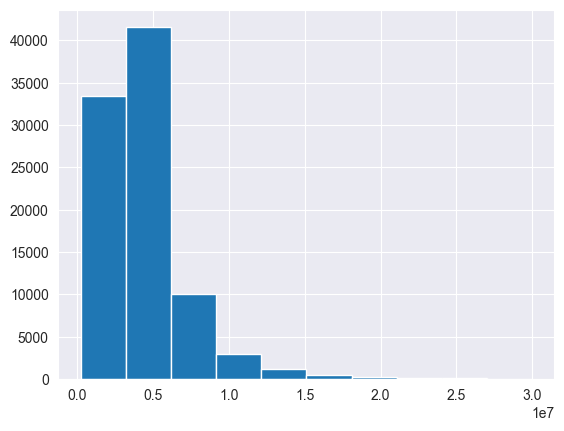

In [8]:
plt.hist(x = df_a['price'])

In [8]:
df = df_a
target = 'price'
X, y = df.drop(columns=[target], axis=1), df[target]

In [9]:
X_cat = X.select_dtypes(include=['object', 'category']).astype('category')
X_num = X.select_dtypes(include=[np.number,'bool','boolean'])
X_num.columns,X_cat.columns

(Index(['areal_befolkning_ArealKm2', 'areal_befolkning_FolkeLandArealKm2',
        'areal_befolkning_Folkemengde', 'areal_befolkning_LandArealKm2',
        'balcony', 'bedrifter_Virksheter', 'bedrooms', 'build_year',
        'collective_assets', 'day', 'dealer_True', 'eq_aircondition_True',
        'eq_charging_possibility_True', 'eq_fireplace_True', 'eq_garden_True',
        'eq_lift_True', 'eq_lift_tmp_True', 'eq_parking_True',
        'eq_parking_tmp_True', 'eq_west_facing_True', 'external_area',
        'fixer_upper_True', 'floor', 'husholdninger_Husholdninger',
        'inntekt_AvtArbTid', 'inntekt_AvtaltManedslonn', 'inntekt_Bonus',
        'inntekt_Manedslonn', 'inntekt_Overtid', 'inntekt_Uregtil',
        'internal_area', 'joint_debt', 'lat', 'lng', 'month',
        'monthly_common_cost', 'ownership_type_andel', 'ownership_type_eier ',
        'plot_size', 'ref_price_pr_i_sqm', 'ref_salgstid', 'rooms',
        'sqm_pr_bedroom', 'sysselsetting_Arbeidssted', 'sysselsetting_Bosatt

In [9]:
def load_data(df,target: str, batch_size: int = 32,log_target = True,num_workers = os.cpu_count()):
    '''
    Load data into PyTorch DataLoader for training and testing.
    :param target:
    :return: tuple of DataLoaders and attributes:  (train_dataloader, test_dataloader,embedding_dims,n_continuous)
    '''

    X, y = df.drop(columns=[target], axis=1), df[target]
    y = np.log1p(y) if log_target else y
    X_cat = X.select_dtypes(include=['object', 'category']).astype('category')
    X_num = X.select_dtypes(include=[np.number,'bool','boolean'])
    if len(X_cat.columns) > 0:
        X_cat_codes = pd.DataFrame({col: X_cat[col].cat.codes.values for col in X_cat.columns})
        embedding_dims = [(len(X_cat[col].cat.categories), min(50, (len(X_cat[col].cat.categories) + 1) // 2)) for col in X_cat.columns.tolist()]
    else:
        X_cat_codes = pd.DataFrame(index = X.index)
        embedding_dims = []
    X_cols,cat_cols,num_cols = X.columns.tolist(),X_cat.columns.tolist(), X_num.columns.tolist()
    other_cols = set(X.columns).difference(set(X_num.columns).union(set(X_cat.columns)))
    if len(other_cols) > 0:
        logger.info(f'Not numeric or category columns: {other_cols}')
        raise ValueError(f'Not numeric or category columns: {other_cols}')
    for col in X_num:
        df[col] = df[col].astype(float)

    X_train_cat, X_test_cat, X_train_num, X_test_num, y_train, y_test = train_test_split(
        X_cat_codes, X_num, y, test_size=0.2, random_state=42
    )

    pipeline = Pipeline(steps = [
                                ('impute', SimpleImputer(strategy='median')),
                                ('scaler', StandardScaler())
                                ])
    
    X_train_num_sc = pipeline.fit_transform(X_train_num)
    X_test_num_sc = pipeline.transform(X_test_num)
    X_train_num_t = torch.from_numpy(X_train_num_sc).type(torch.float)
    X_test_num_t = torch.from_numpy(X_test_num_sc).type(torch.float)
    X_train_cat_t = torch.from_numpy(X_train_cat.to_numpy()).type(torch.long)
    X_test_cat_t = torch.from_numpy(X_test_cat.to_numpy()).type(torch.long)
    y_train_t, y_test_t = torch.from_numpy(y_train.to_numpy()).type(torch.float), torch.from_numpy(y_test.to_numpy()).type(torch.float)
    
        
    train_dataset = TensorDataset(X_train_cat_t,X_train_num_t ,y_train_t)
    test_dataset = TensorDataset(X_test_cat_t,X_test_num_t,y_test_t)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                  num_workers=num_workers)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                 num_workers=num_workers)
    
    n_continuous = X_train_num_t.shape[1]
    logger.info(f'Dataloaders loaded with: {embedding_dims} embedding dimensions and {n_continuous} continuous columns')
    logger.info(f'Train size: {len(train_dataloader.dataset)} | Test size: {len(test_dataset)}')
    return train_dataloader, test_dataloader,embedding_dims,n_continuous

In [10]:
class ANN:

  def __init__(self,df : pd.DataFrame,
               train_dataloader: torch.utils.data.DataLoader,
                test_dataloader: torch.utils.data.DataLoader,
               model : torch.nn.Module,
               learning_rate: float = 0.001,
               weight_decay: float = 0.001,
               logger: Logger = None,
               log_target = True):

    '''
        :param df:
        :param train_dataloader:
        :param test_dataloader:
        :param model:
        :param learning_rate
        :param logger
        :param log_target
        '''

    if not logger:
        logger = Logger('ANN')
    self.logger = logger
    if torch.cuda.is_available():
        self.device = "cuda"
    elif torch.backends.mps.is_available():
        self.device = "mps"
    else:
        self.device = "cpu"
    self.df = df
    self.lr = learning_rate
    self.model = model
    if self.model:
        self.model = model.to(self.device)
        self.optimizer = torch.optim.Adam(params = self.model.parameters(),
                                      lr = self.lr,
                                      weight_decay=weight_decay)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min', patience=3, factor=0.5)
        self.logger.info(f'Model loaded: {self.model.__class__.__name__} with device: {self.device} and learning rate: {self.lr} and log_target: {log_target}')
    self.log_target = log_target
    self.loss_fn = torch.nn.MSELoss()
    self.metric = R2Score().to(self.device)
    self.train_dataloader = train_dataloader
    self.test_dataloader = test_dataloader
    self.n_features = df.shape[1] - 1  # Exclude target column
    self.results = {"train_loss": [], 
                    "train_r2": [], 
                    "test_loss": [], 
                    "test_r2": []}

  def train_step(self):
    self.model.train()
    train_loss = 0
    self.metric.reset()
    for batch,(X_cat,X_num,y) in enumerate(self.train_dataloader):
      X_cat,X_num,y = X_cat.to(self.device),X_num.to(self.device),y.to(self.device).unsqueeze(1)
      y_pred = self.model(X_cat,X_num)
      loss = self.loss_fn(y_pred, y)
      train_loss += loss.item()
      if self.log_target:
          self.metric.update(torch.expm1(y_pred), torch.expm1(y))
      else:
          self.metric.update(y_pred, y)
      self.optimizer.zero_grad()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0) 
      self.optimizer.step()

    train_loss /= len(self.train_dataloader)
    train_r2 = self.metric.compute()
    return train_loss,train_r2

  def test_step(self):
    test_loss = 0
    self.metric.reset()
    self.model.eval()
    with torch.inference_mode():
      for batch,(X_cat,X_num,y) in enumerate(self.test_dataloader):
        X_cat,X_num,y = X_cat.to(self.device),X_num.to(self.device),y.to(self.device).unsqueeze(1)

        # 1. Modellens prediksjon (er på log-skala)
        y_pred = self.model(X_cat,X_num)
        print(f"Batch {batch}: y_pred mean={y_pred.mean().item()}, std={y_pred.std().item()}, y mean={y.mean().item()}, std={y.std().item()}")

        # 2. Beregn loss på log-skala
        loss = self.loss_fn(y_pred, y)
        test_loss += loss.item()

        # 3. Beregn metrikk på original skala
        if self.log_target:
            # Bruk torch.expm1 for å transformere tilbake
            self.metric.update(torch.expm1(y_pred), torch.expm1(y))
        else:
            self.metric.update(y_pred, y)

    test_loss /= len(self.test_dataloader)
    test_r2  = self.metric.compute()
    return test_loss,test_r2

  def train(self,
          epochs : int = 5,
          patience: int = 5,
          min_delta: float = 0.001):

    if not self.model:
        raise ValueError("Model is not loaded. Please load a model before training.")
    results = {"train_loss" : [],
              "train_r2" : [],
              "test_loss" : [],
              "test_r2" : []
              }

    best_loss = float('inf')
    epochs_no_improvement = 0

    for epoch in tqdm(range(epochs)):
      train_loss,train_r2 = self.train_step()
      train_r2 = train_r2.item() if isinstance(train_r2, torch.Tensor) else train_r2
      results['train_loss'].append(train_loss)
      results['train_r2'].append(train_r2)
      test_loss,test_r2 = self.test_step()
      test_r2 = test_r2.item() if isinstance(test_r2, torch.Tensor) else test_r2
      self.scheduler.step(test_loss)
      results['test_loss'].append(test_loss)
      results['test_r2'].append(test_r2)
      print(f'\nEpoch: {epoch} | Train loss: {train_loss:.4f} | Train r2: {train_r2:.4f} | Test loss: {test_loss:.4f} | Test r2: {test_r2:.4f}')
      if test_loss < best_loss - min_delta:
        best_loss = test_loss
        epochs_no_improvement = 0
        self.model_dict = self.model.state_dict()
      else:
        epochs_no_improvement += 1
        if epochs_no_improvement >= patience:
          logger.warning(f'Early stopping at epoch {epoch}. No improvement for {patience} epochs.')

          break
    self.results = results
    return results

  def plot_loss_curves(self):
    loss = self.results['train_loss']
    test_loss = self.results['test_loss']
    r2 = self.results['train_r2']
    test_r2 = self.results['test_r2']
    epochs = range(len(self.results['train_r2']))
    plt.figure(figsize = (16,8))

    plt.subplot(1,2,1)
    plt.plot(epochs,loss,label = 'Train loss')
    plt.plot(epochs,test_loss,label = 'Test loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs,r2,label = 'Train r2')
    plt.plot(epochs,test_r2,label = 'Test r2')
    plt.title('R2 Score')
    plt.xlabel('Epochs')
    plt.legend()

In [11]:
class HomeModel(nn.Module):
    def __init__(self, embedding_dims, n_continuous, hidden_dim=64, output_dim=1,dropout_p = 0.3,logger = None):
        super().__init__()
        if logger is None:
            logger = Logger('PyTorch_training')
        self.logger = logger
        self.embeddings = nn.ModuleList([nn.Embedding(n_cat,n_dim) for n_cat, n_dim in embedding_dims])
        n_embedding_dims = sum(n_dim for _,n_dim in embedding_dims)
        self.embedding_dropout = nn.Dropout(p=dropout_p)
        self.bn_continuous = nn.BatchNorm1d(n_continuous)
        total_input_dim = n_continuous + n_embedding_dims
        self.layer_stack = nn.Sequential(
            nn.BatchNorm1d(total_input_dim),
            nn.Linear(total_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p = dropout_p),

            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p = dropout_p),

            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(p = dropout_p),

            nn.Linear(hidden_dim // 2, output_dim)
        )
        if len(self.embeddings) > 0:
            self.logger.info(f'Training with both numerical and categorical values. {len(self.embeddings)} number of categorical values')
        else:
            self.logger.info(f'Training with only numerical values.')

    def forward(self, x_cat,x_cont):
        if len(self.embeddings)>0:
            embedded_features = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
            x_emb = torch.cat(embedded_features, 1)
            x_emb = self.embedding_dropout(x_emb)
            x_count_norm = self.bn_continuous(x_cont)
            x = torch.cat((x_emb, x_count_norm), 1)
        else:
            x = self.bn_continuous(x_cont)
        return self.layer_stack(x)

In [12]:
df = df_a
target = 'price'
log_target = True
train_dataloader,test_dataloader,embedding_dims,n_continuous = load_data(df = df,target=target, batch_size=32,log_target=log_target)
model_0 = HomeModel(embedding_dims=embedding_dims,
                    n_continuous=n_continuous,
                    hidden_dim=256,
                    output_dim=1,
                    dropout_p = 0.5,
                    )

home_training = ANN(df = df,
                 train_dataloader=train_dataloader,
                 test_dataloader=test_dataloader,
                 model = model_0,
                    learning_rate=0.001,
                    weight_decay=0.001,
                    logger=logger,
                    log_target=log_target)

2025-08-04 13:51:20,510 - train_pytorch_Homes - INFO - Dataloaders loaded with: [] embedding dimensions and 54 continuous columns
2025-08-04 13:51:20,512 - train_pytorch_Homes - INFO - Train size: 72155 | Test size: 18039
2025-08-04 13:51:20,520 - PyTorch_training - INFO - Cloud Logging is disabled. Using local logging to /Users/sigvardbratlie/Documents/Projects/sibr_market_training/logfiles/PyTorch_training.log
2025-08-04 13:51:20,527 - PyTorch_training - INFO - Training with only numerical values.
2025-08-04 13:51:21,542 - train_pytorch_Homes - INFO - Model loaded: HomeModel with device: mps and learning rate: 0.001 and log_target: True


In [13]:
home_training.train(epochs=100, patience=10)

  0%|          | 0/100 [00:00<?, ?it/s]

Batch 0: y_pred mean=15.091670989990234, std=0.5432843565940857, y mean=15.210716247558594, std=0.5809816718101501
Batch 1: y_pred mean=15.034943580627441, std=0.4834073781967163, y mean=15.065625190734863, std=0.6476415395736694
Batch 2: y_pred mean=15.035704612731934, std=0.5503981113433838, y mean=15.062198638916016, std=0.5595073699951172
Batch 3: y_pred mean=15.119674682617188, std=0.4253498613834381, y mean=15.229169845581055, std=0.3978503346443176
Batch 4: y_pred mean=14.884000778198242, std=0.5137737989425659, y mean=15.003851890563965, std=0.595121443271637
Batch 5: y_pred mean=15.222930908203125, std=0.5190720558166504, y mean=15.301162719726562, std=0.5441026091575623
Batch 6: y_pred mean=15.285208702087402, std=0.6484835743904114, y mean=15.276573181152344, std=0.5616994500160217
Batch 7: y_pred mean=15.0713472366333, std=0.5011262893676758, y mean=15.14705753326416, std=0.5443583130836487
Batch 8: y_pred mean=15.17911434173584, std=0.5364491939544678, y mean=15.3407688140

2025-08-04 13:58:49,509 - train_pytorch_Homes - WARNING - Early stopping at epoch 16. No improvement for 10 epochs.



Epoch: 16 | Train loss: 0.3269 | Train r2: -0.1184 | Test loss: 0.2893 | Test r2: -0.0619


{'train_loss': [7.8852905500225905,
  2.9991734252536375,
  1.9654032843340263,
  1.3839645558873195,
  1.0878655445813603,
  0.8971173970503712,
  0.7428674450206122,
  0.6391264851368187,
  0.5566294161152681,
  0.4890632155597078,
  0.4414768572128533,
  0.4030717399789066,
  0.3755439560323491,
  0.35493609964715406,
  0.340935971668845,
  0.3327702441031811,
  0.32692583754097015],
 'train_r2': [-4.780224878193358e+19,
  -12742.826171875,
  -63.6024169921875,
  -9.758837699890137,
  -4.292116165161133,
  -2.3761518001556396,
  -1.4238932132720947,
  -0.944507360458374,
  -0.6511212587356567,
  -0.4633908271789551,
  -0.34633827209472656,
  -0.2608928680419922,
  -0.2070244550704956,
  -0.16680538654327393,
  -0.14131319522857666,
  -0.12985527515411377,
  -0.11836075782775879],
 'test_loss': [6342242.424240173,
  1.2344237635215969,
  4.202499896023713,
  0.29567101484177805,
  0.31837078198420665,
  0.33145773779363075,
  0.2890489735766083,
  0.288947079555257,
  0.2936933353173

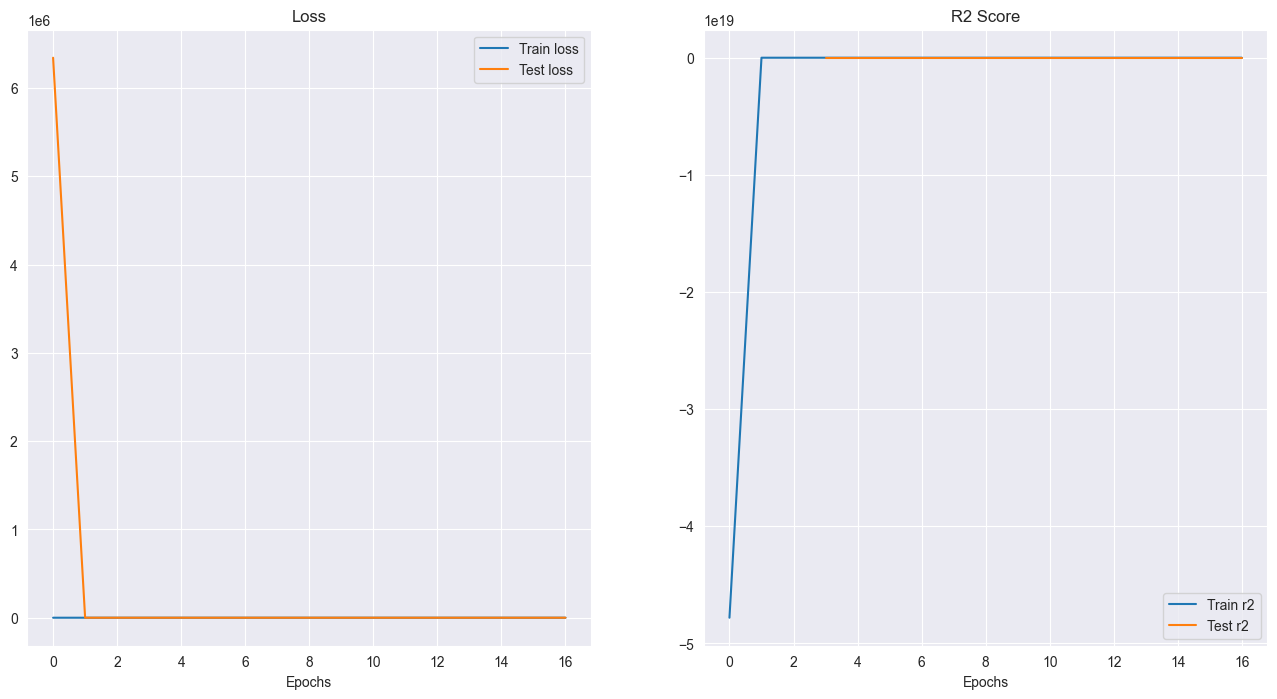

In [14]:
home_training.plot_loss_curves()

In [ ]:
df